**Data preparation** is one of the essential processes in machine learning projects workflow: with well-prepared input even simple algorithm can achieve great result, and without it --- it’s hard to get something meaningful even using the most sophisticated models (remember concept of "[garbage in — garbage out](https://en.wikipedia.org/wiki/Garbage_in,_garbage_out)").

Usually, specific preparation of data for ML modeling can be considered as part of [ETL](https://en.wikipedia.org/wiki/Extract,_transform,_load) process and consists of following steps:

* **feature engineering**: transformation of raw data into proper features, that can be useful for modeling; sometimes, when original data is complex enough (e. g. text, images) this process is also called *feature extraction, feature preparation*.
* **feature selection**: removing unnecessary features (usually it can help to improve model quality/performance/etc).


In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OrdinalEncoder, OneHotEncoder
from sklearn.decomposition import PCA

from sklearn.feature_selection import VarianceThreshold, SelectFromModel, RFECV, SequentialFeatureSelector

from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.metrics import accuracy_score

from sklearn.datasets import make_classification, load_wine, load_breast_cancer, load_diabetes

In [2]:
plt.style.use('seaborn-darkgrid')

In [3]:
def plot_scatter(x, y, auto_scaled=True, title=None, clusters=None):
    plt.figure(figsize=(4, 4))
    plt.scatter(x, y)
    
    if not auto_scaled:
        plt.axis('square')
    
    plt.grid(True)
    plt.title(title)
    
    plt.show()
    
def return_X_y(data, target_column):
    return data.drop(target_column, axis=1), data[target_column]

# Feature Engineering

## Missing Values Preprocessing

In [4]:
housing_data = pd.read_csv('Melbourne_housing_FULL.csv')
# prepare dataset for price regression
housing_data = housing_data[~housing_data['Price'].isnull()]

Missing values are one of the most common problems you can encounter when you try to prepare your data for machine learning. The reason for the missing values might be human errors, interruptions in the data flow, privacy concerns, and so on. Whatever is the reason, missing values affect the performance of the machine learning models (most of the algorithms do not even accept datasets with missing values).

First let's check the amount of missing value in each column of our dataset:

In [5]:
housing_data.isnull().mean() # housing_data.isnull().sum() to get absolute numbers

Suburb           0.000000
Address          0.000000
Rooms            0.000000
Type             0.000000
Price            0.000000
Method           0.000000
SellerG          0.000000
Date             0.000000
Distance         0.000037
Postcode         0.000037
Bedroom2         0.236393
Bathroom         0.236613
Car              0.250450
Landsize         0.340037
BuildingArea     0.608911
YearBuilt        0.556502
CouncilArea      0.000110
Lattitude        0.229530
Longtitude       0.229530
Regionname       0.000110
Propertycount    0.000110
dtype: float64

The most simple strategy is to drop entire rows and/or columns containing missing values based on some threshold (for example, if column contains more than *30%* --- drop it, then drop all rows that still contains some NaN's).

In [6]:
threshold = 0.3
housing_data_dropped = housing_data[housing_data.columns[housing_data.isnull().mean() < threshold]]
housing_data_dropped = housing_data_dropped.dropna(axis=0, how='any') # params is optinal here (matching defaults)
print(f'Original dataset shape (rows, cols): {housing_data.shape}')
print(f'Dataset shape (rows, cols) after dropna: {housing_data_dropped.shape}')

Original dataset shape (rows, cols): (27247, 21)
Dataset shape (rows, cols) after dropna: (20401, 18)


In general dropping data without additional investigation is not a good approach in most cases since you lose a lot of potentially useful information. For this particular dataset we've fully dropped `Landsize`, `BuildingArea` columns (which actually seem like strong features from common sense). 

Usually a better strategy is to impute the missing values, i.e., to infer them from the known part of the data. However, there is an important selection of what you impute to the missing values. You can use default value of missing values in the column. For example, if you have a column that only has `1` and `N\A`, then it is likely that the `N\A` rows may be considered as `0`. 
Another way is to use basic statistics (like *mean* and *medians* of the columns) for imputation.

In [7]:
# const imputing
housing_data_const = housing_data.fillna(value=0)

# mean imputing
housing_data_mean = housing_data.fillna(housing_data.mean())

There are also some advanced technics [KNN Imputation](), [Multivariate imputation]().

But commonly the most beneficial way is to dig deeper in available data, understand root cases of the problem and develop mixed strategy (for separate features based on investigation results). **Subject matter expertise rules!**

For example, one of the questions you may ask yourself to help figure this out is this: 

`Is this value missing because it wasn't recorded or because it doesn’t exist?`

If the value is missing because it doesn’t exist (like the height of the oldest child of someone who doesn't have any children) then it doesn't make sense to try and guess what it might be. These values you probably do want to mark this value using some special tag (or create separate bool feature). On the other hand, if a value is missing because it wasn't recorded, then you may probably use some of the imputation technics mentioned above or even more sophisticated ones.


## Feature scaling

In [8]:
wine_sklearn = load_wine(as_frame=True)
wine_data, wine_labels = wine_sklearn['data'], wine_sklearn['target']
wine_data

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.640000,1.04,3.92,1065.0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.380000,1.05,3.40,1050.0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.680000,1.03,3.17,1185.0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.800000,0.86,3.45,1480.0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.320000,1.04,2.93,735.0
5,14.20,1.76,2.45,15.2,112.0,3.27,3.39,0.34,1.97,6.750000,1.05,2.85,1450.0
6,14.39,1.87,2.45,14.6,96.0,2.50,2.52,0.30,1.98,5.250000,1.02,3.58,1290.0
7,14.06,2.15,2.61,17.6,121.0,2.60,2.51,0.31,1.25,5.050000,1.06,3.58,1295.0
8,14.83,1.64,2.17,14.0,97.0,2.80,2.98,0.29,1.98,5.200000,1.08,2.85,1045.0
9,13.86,1.35,2.27,16.0,98.0,2.98,3.15,0.22,1.85,7.220000,1.01,3.55,1045.0


In real world datasets you can often see multiple features spanning varying degrees of magnitude, range, and units. This is a significant obstacle as a lot of machine learning algorithms are highly sensitive to such things.

To make it simple: algorithm just sees number and does not know what that number represents --- if there is a vast difference in the range say few ranging in thousands and few ranging in dozens, it makes the underlying assumption that higher ranging numbers have superiority of some sort. So, these more significant number starts playing a more decisive role while training the model.

For example, you might be looking at the prices of some products in both Yen and US Dollars. One US Dollar is worth about 100 Yen, but if you don't scale your prices methods like SVM or KNN will consider a difference in price of 1 Yen as important as a difference of 1 US Dollar! This clearly doesn't fit with our intuitions of the world. With currency, you can convert between currencies. But what about if you're looking at something like height and weight? It's not entirely clear how many pounds should equal one inch (or how many kilograms should equal one meter).

By scaling your variables, you can help compare different variables on equal footing (scale).

### Standartization

**Standardization** of datasets is a common requirement for many machine learning models. The idea is to transform the data to the center it by removing the mean value of each feature, then scale it by dividing non-constant features by their standard deviation.

$$scaled\_X = \frac{X - mean(X)}{std(X)}$$, where $X$ is **feature column** (not dataset itself!)

A common approach is to use `StandardScaler` from `sklearn`:


In [9]:
scaler = StandardScaler()
wine_data_scaled = scaler.fit_transform(wine_data)
wine_data_scaled

array([[ 1.51861254, -0.5622498 ,  0.23205254, ...,  0.36217728,
         1.84791957,  1.01300893],
       [ 0.24628963, -0.49941338, -0.82799632, ...,  0.40605066,
         1.1134493 ,  0.96524152],
       [ 0.19687903,  0.02123125,  1.10933436, ...,  0.31830389,
         0.78858745,  1.39514818],
       ...,
       [ 0.33275817,  1.74474449, -0.38935541, ..., -1.61212515,
        -1.48544548,  0.28057537],
       [ 0.20923168,  0.22769377,  0.01273209, ..., -1.56825176,
        -1.40069891,  0.29649784],
       [ 1.39508604,  1.58316512,  1.36520822, ..., -1.52437837,
        -1.42894777, -0.59516041]])

Let's illustrate the influence of scaling on [PCA](https://en.wikipedia.org/wiki/Principal_component_analysis):

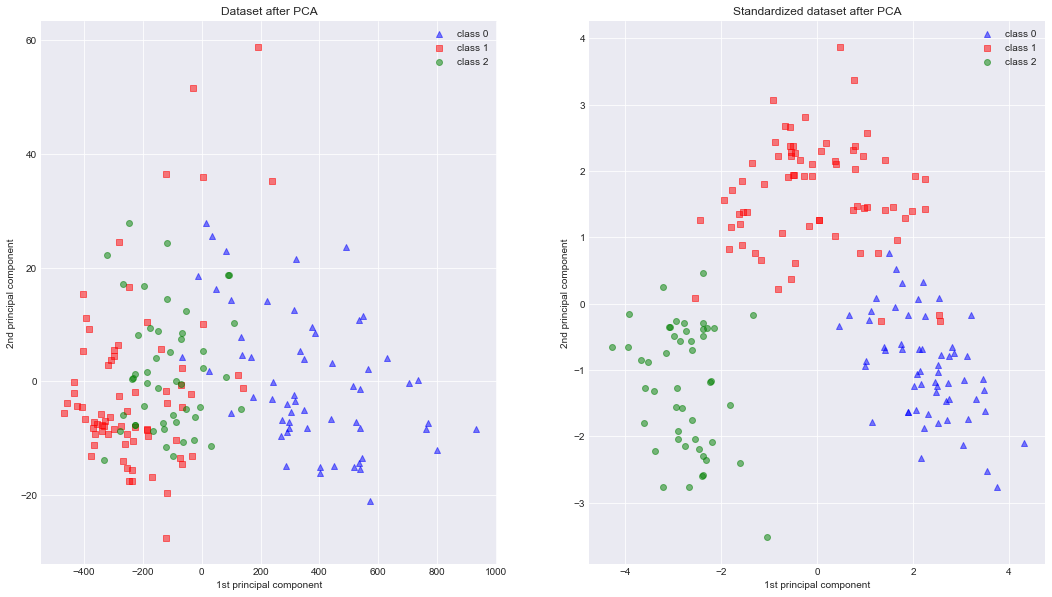

In [10]:
pca = PCA(n_components=2)

wine_data_pca = pca.fit_transform(wine_data)
wine_data_scaled_pca = pca.fit_transform(wine_data_scaled)

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(18, 10))

for l, c, m in zip(range(0, 3), ('blue', 'red', 'green'), ('^', 's', 'o')):
    ax1.scatter(wine_data_pca[wine_labels == l, 0], wine_data_pca[wine_labels == l, 1], 
                color=c, label=f'class {l}', alpha=0.5, marker=m)

for l, c, m in zip(range(0, 3), ('blue', 'red', 'green'), ('^', 's', 'o')):
    ax2.scatter(wine_data_scaled_pca[wine_labels == l, 0], wine_data_scaled_pca[wine_labels == l, 1], 
                color=c, label=f'class {l}', alpha=0.5, marker=m)
    
ax1.set_title('Dataset after PCA')
ax2.set_title('Standardized dataset after PCA')

for ax in (ax1, ax2):
    ax.set_xlabel('1st principal component')
    ax.set_ylabel('2nd principal component')
    ax.legend(loc='upper right')

### Normalization

An alternative standardization is scaling features to lie between a given minimum and maximum value, often between zero and one, or so that the maximum absolute value of each feature is scaled to unit size (also known as **Normalization**.  This can be achieved using `MinMaxScaler` or `MaxAbsScaler` from `sklearn`, respectively.

The motivation to use this scaling include robustness to very small standard deviations of features and preserving zero entries in sparse data.

$$normalised\_X = \frac{X - min(X)}{max(X) - min(X)}$$, where $X$ is **feature column** (not dataset itself!)

In [11]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaler.fit_transform(wine_data)

array([[0.84210526, 0.1916996 , 0.57219251, ..., 0.45528455, 0.97069597,
        0.56134094],
       [0.57105263, 0.2055336 , 0.4171123 , ..., 0.46341463, 0.78021978,
        0.55064194],
       [0.56052632, 0.3201581 , 0.70053476, ..., 0.44715447, 0.6959707 ,
        0.64693295],
       ...,
       [0.58947368, 0.69960474, 0.48128342, ..., 0.08943089, 0.10622711,
        0.39728959],
       [0.56315789, 0.36561265, 0.54010695, ..., 0.09756098, 0.12820513,
        0.40085592],
       [0.81578947, 0.66403162, 0.73796791, ..., 0.10569106, 0.12087912,
        0.20114123]])

## Log/Power Transform

Log transformation is a data transformation method in which it replaces each variable $x$ with a $log(x)$. The choice of the logarithm base is usually left up to the analyst and it would depend on the purposes of statistical modeling.

When our original continuous data do not follow the bell curve, we can log transform this data to make it as “normal” as possible so that the statistical analysis results from this data become more valid. In other words, the log transformation reduces or removes the skewness of our original data. The important caveat here is that the original data has to approximately follow a *log-normal distribution*. Otherwise, you can't expect any guarantees that result distribution will be close to normal (but even in such cases log transform can help to improve you scores).

In [12]:
mu, sigma = 5, 1
lognorm_data = np.random.lognormal(mu, sigma, 1000)

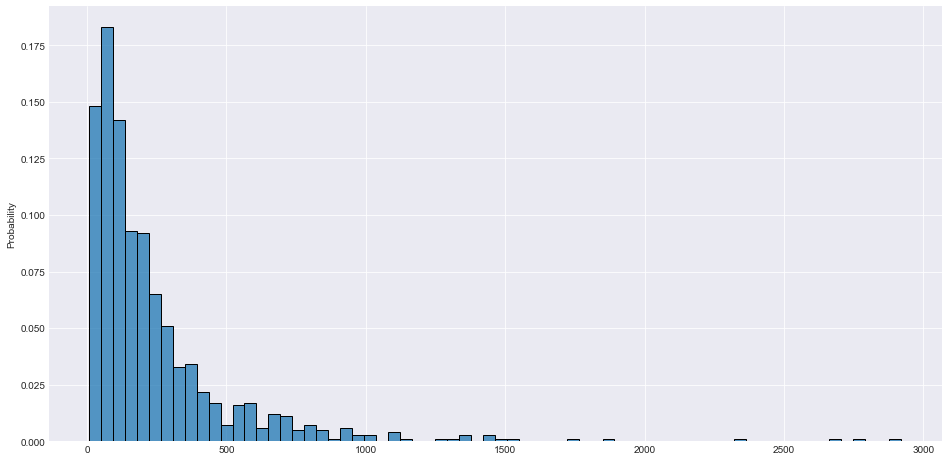

In [13]:
plt.figure(figsize=(16,8))
sns.histplot(lognorm_data, stat='probability')
plt.show()

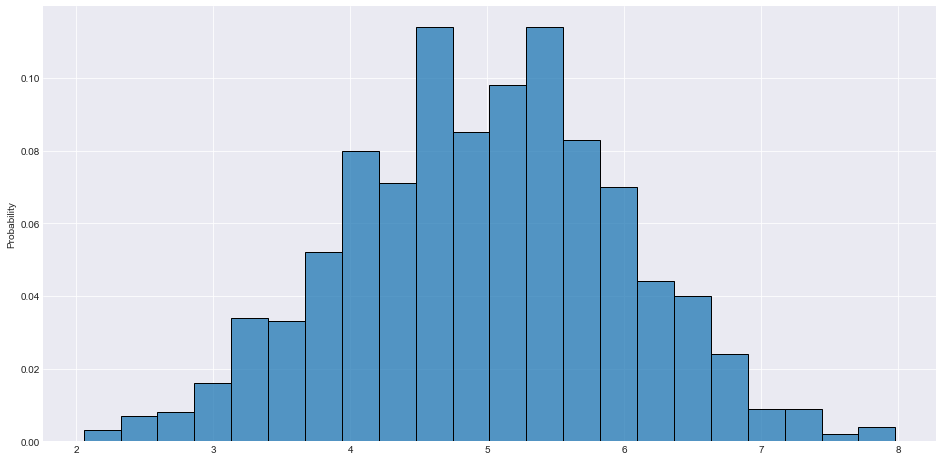

In [14]:
plt.figure(figsize=(16,8))
sns.histplot(np.log(lognorm_data), stat='probability')
plt.show()

This may sound a bit odd: is it even possible to meet something specific like "log-normal distribution" in real life?

Well, let's plot the price column from Melbourne housing dataset, that we used previously:

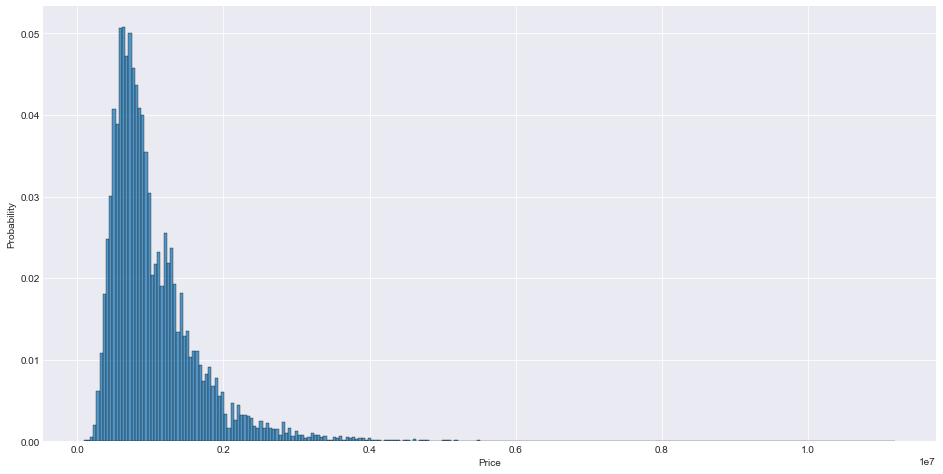

In [15]:
plt.figure(figsize=(16,8))
sns.histplot(housing_data['Price'], stat='probability')
plt.show()

Seems familiar!

Eventually, lognormal distribution of some value in real world is quite common (just like normal distribution). It is suitable for describing length of comments, posted in the internet; the salaries amount; the population of cities and many other things. You may find some [more](https://en.wikipedia.org/wiki/Log-normal_distribution#Occurrence_and_applications) examples just on the wikipedia page.

However, to get some profit from this transformation, the distribution does not necessarily have to be *exactly* lognormal; you can try to apply it to any distribution with a heavy right tail. Furthermore, one can try to use other similar transformations, formulating their own hypotheses on how to approximate the available distribution to a normal. Examples of such transformations are Box-Cox transformation (log is a special case of the Box-Cox transformation) or Yeo-Johnson transformation (extends the range of applicability to negative numbers). Some information about these transformations and their implementations in `sklean` can be found [here](https://scikit-learn.org/stable/modules/preprocessing.html#non-linear-transformation).

## Categorical Features Encoding

Quite often features are not given as continuous values but categorical. For example a person could have features `["male", "female"], ["from Europe", "from US", "from Asia"], ["uses Firefox", "uses Chrome", "uses Safari", "uses Internet Explorer"]`. Such features can be efficiently coded as integers, for instance `["male", "from US", "uses Internet Explorer"]` could be expressed as `[0, 1, 3]` while `["female", "from Asia", "uses Chrome"]` would be `[1, 2, 1]`.

To convert categorical features to such integer codes, we can use the *ordinal encoding*. It transforms each categorical feature to a range of integers (0 to number of categories - 1).

In [16]:
X = [['male', 'US', 'Safari'], ['female', 'Europe', 'Firefox'], ['male', 'Europe', 'Opera']]
pd.DataFrame(X, columns=['gender', 'place', 'browser'])

,gender,place,browser
0,male,US,Safari
1,female,Europe,Firefox
2,male,Europe,Opera


In [17]:
encoder = OrdinalEncoder()
ordinal_encoded_X = encoder.fit_transform(X)
ordinal_encoded_X

array([[1., 1., 2.],
       [0., 0., 0.],
       [1., 0., 1.]])

Such integer representation can, however, can be unsuitable, for a lot of models: these expect continuous input, and would interpret the categories as being ordered, which is often not desired.

Another possibility to convert categorical features to features that can be used with scikit-learn estimators is to use *one-hot* encoding. The idea is to transforms each categorical feature, that has $n$ different possible categories, into $n$ separate binary features (whether the object belongs to specific category or not).

In [18]:
encoder = OneHotEncoder()
ohe_encoded_X = encoder.fit_transform(X).toarray()

In [19]:
pd.DataFrame(ohe_encoded_X, columns=encoder.get_feature_names())

,x0_female,x0_male,x1_Europe,x1_US,x2_Firefox,x2_Opera,x2_Safari
0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
1,1.0,0.0,1.0,0.0,1.0,0.0,0.0
2,0.0,1.0,1.0,0.0,0.0,1.0,0.0


It is also possible to encode each column into  $n - 1$ columns instead of $n$ columns by using the drop parameter (also called *dummy encoding*). This is useful to avoid co-linearity in the input matrix in some classifiers. Such functionality is useful, for example, when using non-regularized regression, since co-linearity would cause the covariance matrix to be non-invertible.

You can read about some advanced technics [here](https://www.analyticsvidhya.com/blog/2020/08/types-of-categorical-data-encoding). However, most of them equivalent to one hot encoding to some degree.


# Feature Selection

Why is it sometimes necessary to select just subset of features and not all at once? The idea of removing features may seem a little counterintuitive, but there is some import motivation here:

1) First is more connected to engeneering side: the more data, the higher the computational complexity. Removing some unimportant and noisy features can help a lot here.    
2) The second reason is related to algorithms side: some models can be unstable when data have highly correlated features ([multicolinearity](https://datascience.stackexchange.com/questions/24452/in-supervised-learning-why-is-it-bad-to-have-correlated-features)), some --- when data is noisy. 

In [20]:
cancer_sklearn = load_breast_cancer(as_frame=True)
cancer_data, cancer_labels = cancer_sklearn['data'], cancer_sklearn['target']
cancer_data_scaled = StandardScaler().fit_transform(cancer_data)
cancer_data

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,17.990,10.38,122.80,1001.0,0.11840,0.27760,0.300100,0.147100,0.2419,0.07871,...,25.380,17.33,184.60,2019.0,0.16220,0.66560,0.71190,0.26540,0.4601,0.11890
1,20.570,17.77,132.90,1326.0,0.08474,0.07864,0.086900,0.070170,0.1812,0.05667,...,24.990,23.41,158.80,1956.0,0.12380,0.18660,0.24160,0.18600,0.2750,0.08902
2,19.690,21.25,130.00,1203.0,0.10960,0.15990,0.197400,0.127900,0.2069,0.05999,...,23.570,25.53,152.50,1709.0,0.14440,0.42450,0.45040,0.24300,0.3613,0.08758
3,11.420,20.38,77.58,386.1,0.14250,0.28390,0.241400,0.105200,0.2597,0.09744,...,14.910,26.50,98.87,567.7,0.20980,0.86630,0.68690,0.25750,0.6638,0.17300
4,20.290,14.34,135.10,1297.0,0.10030,0.13280,0.198000,0.104300,0.1809,0.05883,...,22.540,16.67,152.20,1575.0,0.13740,0.20500,0.40000,0.16250,0.2364,0.07678
5,12.450,15.70,82.57,477.1,0.12780,0.17000,0.157800,0.080890,0.2087,0.07613,...,15.470,23.75,103.40,741.6,0.17910,0.52490,0.53550,0.17410,0.3985,0.12440
6,18.250,19.98,119.60,1040.0,0.09463,0.10900,0.112700,0.074000,0.1794,0.05742,...,22.880,27.66,153.20,1606.0,0.14420,0.25760,0.37840,0.19320,0.3063,0.08368
7,13.710,20.83,90.20,577.9,0.11890,0.16450,0.093660,0.059850,0.2196,0.07451,...,17.060,28.14,110.60,897.0,0.16540,0.36820,0.26780,0.15560,0.3196,0.11510
8,13.000,21.82,87.50,519.8,0.12730,0.19320,0.185900,0.093530,0.2350,0.07389,...,15.490,30.73,106.20,739.3,0.17030,0.54010,0.53900,0.20600,0.4378,0.10720
9,12.460,24.04,83.97,475.9,0.11860,0.23960,0.227300,0.085430,0.2030,0.08243,...,15.090,40.68,97.65,711.4,0.18530,1.05800,1.10500,0.22100,0.4366,0.20750


## Statistical Approaches

The most obvious candidate for removal is a feature whose value remains unchanged, i.e., it contains no information at all. If we build on this thought, it is reasonable to say that features with low variance are worse than those with high variance. So, one can consider cutting features with variance below a certain threshold.

In [21]:
X_generated, y_generated = make_classification(n_samples=1000, n_features=25, n_informative=3,
                                                         n_redundant=2, n_repeated=0)
X_generated.shape

(1000, 25)

In [22]:
print(VarianceThreshold(0.9).fit_transform(X_generated).shape)
print(VarianceThreshold(1).fit_transform(X_generated).shape)
print(VarianceThreshold(1.1).fit_transform(X_generated).shape)

(1000, 24)
(1000, 13)
(1000, 4)


Keep in mind that we are using absolute value as threshold, so in real world scenario it is necessary to bring all the features to same scale (perform scaling before thresholding).

Personally, I won't recommend using `VarianceTreshold` unless you are completely sure that it's needed and won't make things worse: the low variance does not necessarily mean that feature is not informative. You can also try [other](https://scikit-learn.org/stable/modules/feature_selection.html#univariate-feature-selection) a little bit more advanced statistical approaches.

## Selection From Modeling


Basically, the idea is to use some model as an feature importance estimator: for example, we can use linear model with `Lasso` regularization (and feature weights from it) or some tree based models (which have natural ability to compute feature importance). Then, based on received importance/weights we can choose some threshold and take features, that have importance above this value.

In [23]:
selection_model = RandomForestClassifier(random_state=42)
selector = SelectFromModel(selection_model).fit(cancer_data, cancer_labels)
cancer_data_pruned = selector.transform(cancer_data)
print(cancer_data.columns[selector.get_support()])
print(f'Original shape: {cancer_data.shape}')
print(f'Shape after selection: {cancer_data_pruned.shape}')

Index(['mean radius', 'mean perimeter', 'mean area', 'mean concavity',
       'mean concave points', 'worst radius', 'worst perimeter', 'worst area',
       'worst concavity', 'worst concave points'],
      dtype='object')
Original shape: (569, 30)
Shape after selection: (569, 10)


In [24]:
main_model = LogisticRegression(solver='liblinear', penalty='l1')
pipe_baseline = make_pipeline(StandardScaler(), main_model)
pipe_selection = make_pipeline(StandardScaler(), SelectFromModel(selection_model), main_model) # fix to select only once

print('Result on original data: {:f}'.format(cross_val_score(pipe_baseline, cancer_data, cancer_labels, 
                      scoring='accuracy', cv=5).mean()))

print('Result after selection {:f}'.format(cross_val_score(pipe_selection, cancer_data, cancer_labels, 
                      scoring='accuracy', cv=5).mean()))

Result on original data: 0.970160
Result after selection 0.949045


We were able to reduce the number of features significantly, but, as you can see, stable performance is not guaranteed.

It's also possible to use same model as an importance estimator and actual classifier (regressor).
As a development of this approach we can consider recursive feature elimination: first, the model is trained on the initial set of features and the importance of each feature is obtained. Then, the least important features are pruned from current set of features. That procedure is recursively repeated on the pruned set until the desired number of features to select is eventually reached.

In [25]:
min_features_to_select = 1 
rfecv = RFECV(estimator=main_model, step=1, cv=KFold(3), 
              scoring='accuracy', min_features_to_select=min_features_to_select)
rfecv.fit(cancer_data_scaled, cancer_labels)

print("Optimal number of features : %d" % rfecv.n_features_)


Optimal number of features : 15


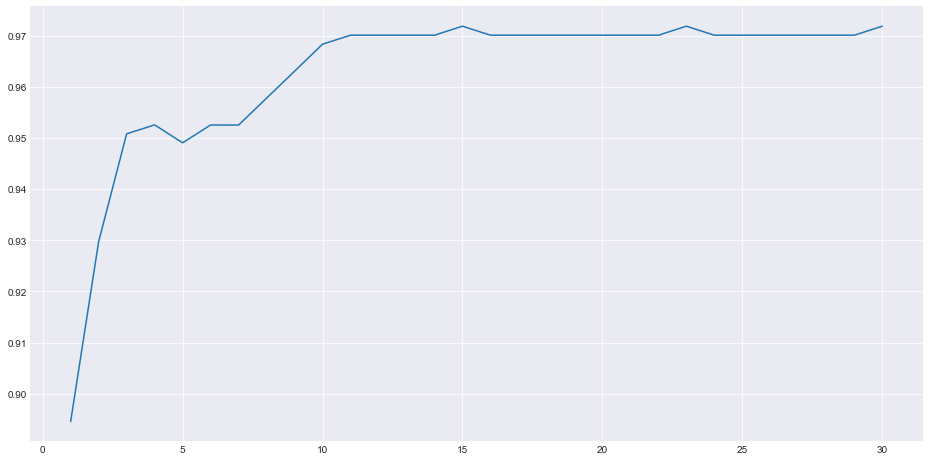

In [26]:
plt.figure(figsize=(16,8))
plt.plot(range(min_features_to_select,
               len(rfecv.grid_scores_) + min_features_to_select),
         rfecv.grid_scores_)
plt.show()

## Greedy (Sequential) Feature Selection 

Finally, we get to the most reliable method --- trivial brute force: just test all possible subsets of features (train a model on a subset of features, store results, repeat for different subsets, and compare the quality of models to identify the best feature set). This approach is called [Exhaustive Feature Selection](http://rasbt.github.io/mlxtend/user_guide/feature_selection/ExhaustiveFeatureSelector).

However, usually this method is too computationally complex to use for some real word dataset (it's even not available in scikit-learn). To reduce complexity one can the following *greedy* heuristic:  tart with zero feature and find the one feature that maximizes a cross-validated score when the model is trained on this single feature. Once that first feature is selected, we repeat the procedure by adding a new feature to the set of selected features. It is possible to iterate until we hit (preselected) maximum number of features or until the quality of the model ceases to increase significantly between iterations.

This algorithm can work in the opposite direction: instead of starting with no feature and greedily adding features, we start with all the features and greedily remove features from the set.

In [27]:
selector = SequentialFeatureSelector(main_model, scoring='accuracy', n_jobs=-1).fit(cancer_data_scaled, cancer_labels)
cancer_data_scaled_pruned = selector.transform(cancer_data_scaled)

print(cancer_data.columns[selector.get_support()])
print(f'Original shape: {cancer_data.shape}')
print(f'Shape after selection: {cancer_data_pruned.shape}\n')

print('Result on original data: {:f}'.format(cross_val_score(main_model, cancer_data_scaled, 
                                                           cancer_labels, scoring='accuracy', cv=5).mean()))

print('Result after selection {:f}'.format(cross_val_score(main_model, cancer_data_scaled_pruned, 
                                                        cancer_labels, scoring='accuracy', cv=5).mean()))

Index(['mean radius', 'mean texture', 'mean perimeter', 'mean area',
       'mean smoothness', 'mean concavity', 'mean concave points',
       'texture error', 'smoothness error', 'concavity error',
       'symmetry error', 'worst radius', 'worst texture', 'worst perimeter',
       'worst smoothness'],
      dtype='object')
Original shape: (569, 30)
Shape after selection: (569, 10)

Result on original data: 0.975423
Result after selection 0.980686


# Homework

## Exercise  1 - Scaling (3 points)

Perform standardization for wine dataset (`wine_data`) using only basic python, numpy and pandas (without using `StandardScaler` and sklearn at all). Implementation of function (or class) that can get dataset as input and return standardized dataset as output is preferrable, but not necessary.

Compare you results (output) with `StandardScaler`.

**NOTE:**

1) 1.5 points is for correct wine dataset standardization and another 1.5 points is for implementation of standardization function, that is working in more general case.

2) "General case" doesn't mean, that you need to handle some/all really "specific" cases (datasets with missing/categorial variables, very large dataset, etc). Let's assume that it should work with numeric datasets of reasonable shape: showing the output for one or two randomly generated 10x10 dataset and comparing the results with `StandardScaler` should be enough (or you can be more creative).



In [28]:
wine_sklearn = load_wine(as_frame=True)
wine_data, wine_labels = wine_sklearn['data'], wine_sklearn['target']
wine_data.head()

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0


In [29]:
## function for standart scaling
def standart_scaler(dataset):
    dataset_new = dataset.apply(lambda column: (column - np.mean(column))/np.std(column), axis=0)
    return dataset_new

Let's apply this function to wine_data, then save it as array.

In [30]:
wine_data_scaled_by_me = standart_scaler(wine_data)
wine_data_scaled_by_me = np.asarray(wine_data_scaled_by_me)
wine_data_scaled_by_me

array([[ 1.51861254, -0.5622498 ,  0.23205254, ...,  0.36217728,
         1.84791957,  1.01300893],
       [ 0.24628963, -0.49941338, -0.82799632, ...,  0.40605066,
         1.1134493 ,  0.96524152],
       [ 0.19687903,  0.02123125,  1.10933436, ...,  0.31830389,
         0.78858745,  1.39514818],
       ...,
       [ 0.33275817,  1.74474449, -0.38935541, ..., -1.61212515,
        -1.48544548,  0.28057537],
       [ 0.20923168,  0.22769377,  0.01273209, ..., -1.56825176,
        -1.40069891,  0.29649784],
       [ 1.39508604,  1.58316512,  1.36520822, ..., -1.52437837,
        -1.42894777, -0.59516041]])

Now let's use sklearn StandardScaler() 

In [31]:
scaler = StandardScaler()
wine_data_scaled = scaler.fit_transform(wine_data)
wine_data_scaled

array([[ 1.51861254, -0.5622498 ,  0.23205254, ...,  0.36217728,
         1.84791957,  1.01300893],
       [ 0.24628963, -0.49941338, -0.82799632, ...,  0.40605066,
         1.1134493 ,  0.96524152],
       [ 0.19687903,  0.02123125,  1.10933436, ...,  0.31830389,
         0.78858745,  1.39514818],
       ...,
       [ 0.33275817,  1.74474449, -0.38935541, ..., -1.61212515,
        -1.48544548,  0.28057537],
       [ 0.20923168,  0.22769377,  0.01273209, ..., -1.56825176,
        -1.40069891,  0.29649784],
       [ 1.39508604,  1.58316512,  1.36520822, ..., -1.52437837,
        -1.42894777, -0.59516041]])

In order to understand how is it going, let's compare two results:

In [32]:
# check wine dataset standartization
assert np.allclose(wine_data_scaled_by_me, wine_data_scaled, rtol=1e-06), "Arrays scaled by StandartScaler() and by custom function are not equal!"

What if we have a random dataset? Will our custom function work?
Let's generate some data.

In [33]:
# general case
df = pd.DataFrame(np.random.randint(0,100,size=(10, 10)), columns=list('ABCDEFGHIJ'))
df

,A,B,C,D,E,F,G,H,I,J
0,31,78,99,41,86,64,65,5,33,60
1,97,90,47,65,29,81,74,81,50,20
2,48,9,18,61,6,84,3,33,34,75
3,80,14,39,57,54,94,81,97,56,69
4,8,9,87,72,98,84,69,63,56,63
5,25,59,55,74,41,1,18,3,70,78
6,28,11,81,49,74,90,32,48,10,93
7,84,78,74,41,32,21,8,7,26,18
8,69,30,80,11,77,95,37,52,39,35
9,95,41,80,38,93,71,32,57,30,31


As with wine_data, let's apply custom function and sklearn StandardScaler(): 

In [34]:
df_scaled_by_me = np.asarray(standart_scaler(df))
df_scaled_by_me
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df)
df_scaled

array([[-0.82879183,  1.18677467,  1.37907621, -0.54706153,  0.91318415,
        -0.14763624,  0.85609004, -1.28639248, -0.44283599,  0.23252891],
       [ 1.31631643,  1.5812704 , -0.79401358,  0.77914823, -1.01464905,
         0.41010066,  1.18963162,  1.18244158,  0.57448993, -1.37111873],
       [-0.27626394, -1.08157581, -2.00592904,  0.55811327, -1.79254666,
         0.50852482, -1.44164081, -0.37682204, -0.38299328,  0.83389677],
       [ 0.76378855, -0.91720258, -1.12833508,  0.33707831, -0.16910818,
         0.83660535,  1.44905285,  1.70219611,  0.93354613,  0.59334963],
       [-1.57632956, -1.08157581,  0.87759395,  1.16595942,  1.31904377,
         0.50852482,  1.00433075,  0.59771772,  0.93354613,  0.35280248],
       [-1.02380167,  0.56215642, -0.45969207,  1.2764769 , -0.60878943,
        -2.21454357, -0.88573818, -1.3513618 ,  1.77134394,  0.95417034],
       [-0.92629675, -1.01582652,  0.62685282, -0.10499161,  0.50732453,
         0.70537314, -0.36689573,  0.11044784

Finally, let's check whether our custom function perfoms as well as the StandartScaler:

In [35]:
# check general case standartization
assert np.allclose(df_scaled_by_me, df_scaled, rtol=1e-06), "Arrays scaled by StandartScaler() and by custom function are not equal!"

## Exercise  2 - Visualization (4 points)

As noted earlier, standardization/normalization of data can be crucial for some distance-based ML methods.

Let’s generate some toy example of unnormalized data and visualize the importance of this process once more:

In [36]:
feature_0 = np.random.randn(1000) * 10   
feature_1 = np.concatenate([np.random.randn(500), np.random.randn(500) + 5])
data = np.column_stack([feature_0, feature_1])
data 

array([[ -5.94604692,  -0.37968801],
       [ 17.2446816 ,   0.49852213],
       [-15.42330948,  -1.2130047 ],
       ...,
       [ -0.11792337,   3.92502933],
       [  1.34205684,   5.29787392],
       [  4.50111647,   5.57670566]])

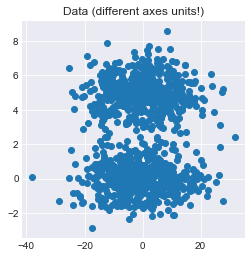

In [37]:
plot_scatter(data[:, 0],  data[:, 1], auto_scaled=True, title='Data (different axes units!)')

**NOTE:** on the plot above axes are scaled differently and we can clearly see two potential *classes/clusters*. In fact `matplotlib` performed `autoscaling` (which is basically can be considered as `MinMaxScaling` of original data) just for better visualization purposes.

Let's turn this feature off and visualize the original data on the plot with equally scaled axes:

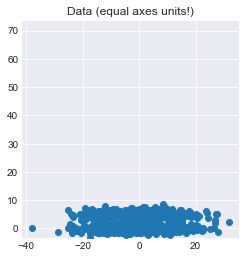

In [38]:
plot_scatter(data[:, 0], data[:, 1], auto_scaled=False , title='Data (equal axes units!)')

This picture is clearly less interpretable, but much closer to "how distance-based algorithm see the original data": separability of data is hardly noticable only because the variation (std) of x-feature is much bigger in absolute numbers.

Perform `StandardScaling` and `MinMaxScaling` of original data; visualize results for each case (**use `plot_scatter` with `auto_scaled=False`**):

### MinMaxScaling (1 point)

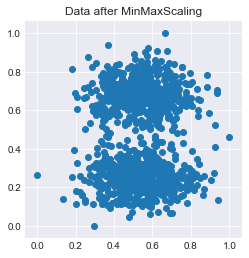

array([[0.45805176, 0.21827249],
       [0.78986962, 0.29493713],
       [0.32244908, 0.14552688],
       ...,
       [0.54144179, 0.59405912],
       [0.5623315 , 0.71390361],
       [0.60753199, 0.73824463]])

In [39]:
## your code

scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data)


plot_scatter(data_scaled[:, 0], data_scaled[:, 1], auto_scaled=False , title='Data after MinMaxScaling')
data_scaled

### StandardScaler (1 point)

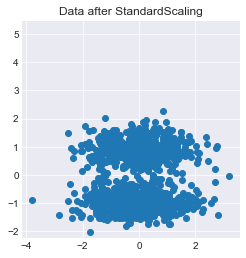

array([[-0.57646413, -1.08268967],
       [ 1.74394304, -0.75265473],
       [-1.52473568, -1.39585347],
       ...,
       [ 0.00668356,  0.5350406 ],
       [ 0.15276558,  1.05096118],
       [ 0.46885331,  1.15574728]])

In [40]:
## your code
scaler = StandardScaler()
data_scaled_2 = scaler.fit_transform(data)

plot_scatter(data_scaled_2[:, 0], data_scaled_2[:, 1], auto_scaled=False , title='Data after StandardScaling')
data_scaled_2

### (Bonus) K-means (2 points)

Illustrate the impact of scaling on basic distance-based clustering algorithm [K-means](https://towardsdatascience.com/understanding-k-means-clustering-in-machine-learning-6a6e67336aa1) using `data` generated above.

**NOTE:** basically, you don't need understanding K-means algorithm here, you just need to:

1) run algorithm (with k=2, k - number of clusters/classes) on unscaled data    
2) run algorithm (with k=2) on scaled data    
3) plot results: highlight different clusters using different colors.

You can use this [question](https://stats.stackexchange.com/questions/89809/is-it-important-to-scale-data-before-clustering/89813) as a hint, but I recommend you to plot results using `plot_scatter` with `equal_scaled=True`: it might help you to intuitively understand the reasons of such scaling impact.


Firstly, we need to plot original data. Then let's train K-means algorithm (without any scaling) and plot the result:

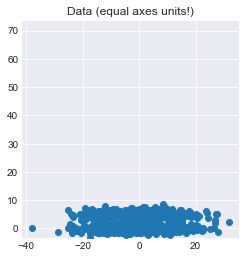

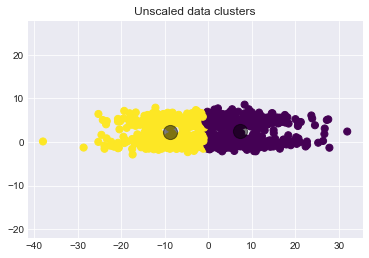

In [41]:
from sklearn.cluster import KMeans

plot_scatter(data[:, 0], data[:, 1], auto_scaled=False , title='Data (equal axes units!)')

km = KMeans(n_clusters=2)

clusters = km.fit_predict(data)
plt.scatter(data[:, 0], data[:, 1], c=clusters, s=50, cmap='viridis')
plt.title('Unscaled data clusters')
plt.axis('equal')
centers = km.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5);

The second step - let's use data_scaled (original data after MinMaxScaler), then train the model and plot the result: 

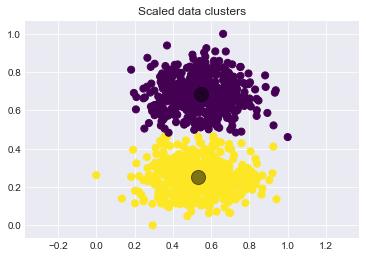

In [42]:
clusters2 = km.fit_predict(data_scaled)
plt.scatter(data_scaled[:, 0], data_scaled[:, 1], c=clusters2, s=50, cmap='viridis')
plt.title('Scaled data clusters')
plt.axis('equal')
centers2 = km.cluster_centers_
plt.scatter(centers2[:, 0], centers2[:, 1], c='black', s=200, alpha=0.5);

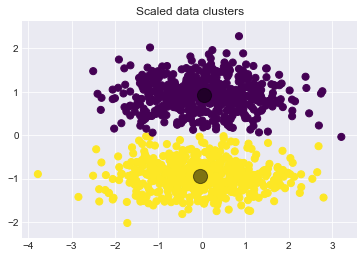

In [43]:
clusters3 = km.fit_predict(data_scaled_2)
plt.scatter(data_scaled_2[:, 0], data_scaled_2[:, 1], c=clusters2, s=50, cmap='viridis')
plt.title('Scaled data clusters')
plt.axis('equal')
centers3 = km.cluster_centers_
plt.scatter(centers3[:, 0], centers3[:, 1], c='black', s=200, alpha=0.5);

Without any scaling, the algorithm saw the data as a flattened array and it was hard to figure out where real clusters were. After scaling, it managed to process data more accurately. 

## Exercise  3 - Preprocessing Pipeline (3 points)

In [66]:
wine_train, wine_val, wine_labels_train, wine_labels_val = train_test_split(wine_data, wine_labels, 
                                                                            test_size=0.3, random_state=42)

Train model (for example, `LogisticRegression(solver='liblinear', penalty='l1')` on raw `wine_train` data; then train same model after data scaling; then add feature selection (and train model again on scaled data).

Measure `accuracy` of all 3 approaches on `wine_val` dataset. Describe and explain results.

In [67]:
clf = LogisticRegression(solver='liblinear', penalty='l1')
clf.fit(wine_train, wine_labels_train)
labels_pred = clf.predict(wine_val)
print('Result on raw data: {:f}'.format(clf.score(wine_val, wine_labels_val)))


Result on raw data: 0.981481


In [68]:
pipe = make_pipeline(StandardScaler(), LogisticRegression(solver='liblinear', penalty='l1'))
pipe.fit(wine_train, wine_labels_train)  # apply scaling on training data
print('Result on scaled data: {:f}'.format(pipe.score(wine_val, wine_labels_val)))  # apply scaling on testing data, without leaking training data.

Result on scaled data: 0.981481


In [69]:
pipe_selection = make_pipeline(StandardScaler(), SelectFromModel(selection_model),  LogisticRegression(solver='liblinear', penalty='l1'))
pipe_selection.fit(wine_train, wine_labels_train)  # apply scaling on training data
print('Result on scaled data, after selection: {:f}'.format(pipe_selection.score(wine_val, wine_labels_val)))  # apply scaling on testing data, without leaking training data.

Result on scaled data, after selection: 1.000000


* Additional code: here I measured accuracy on train data with cross-validation.

In [71]:
main_model = LogisticRegression(solver='liblinear', penalty='l1')
pipe_scaled = make_pipeline(StandardScaler(), main_model)
pipe_selection = make_pipeline(StandardScaler(), SelectFromModel(selection_model), main_model)

print('Result on original data: {:f}'.format(cross_val_score(main_model, wine_data, wine_labels, 
                      scoring='accuracy', cv=5).mean()))
print('Result on scaled data: {:f}'.format(cross_val_score(pipe_scaled, wine_data, wine_labels, 
                      scoring='accuracy', cv=5).mean()))
print('Result after selection: {:f}'.format(cross_val_score(pipe_selection, wine_data, wine_labels, 
                      scoring='accuracy', cv=5).mean()))

Result on original data: 0.961111
Result on scaled data: 0.983333
Result after selection: 0.983333


This task allows to make such conclusions:
- result depends much on how we split the data (I had different scores with different random_state)
- accuracy of all 3 approaches on wine_val doesn't vary before and after scaling, and equals 1 after feature selection (random_state=42)
- with cross-validation accuracy of train data is more after Scaling, but remains the same after selection

I think that it depends on the algorithm - some of them are more sensitive to such preprocessing steps. Surely, the underlying data has a big impact as well - perhaps, we have a rather good dataset so scaling didn't manage to improve the model accuracy much. Given the fact that this dataset is rather small and has a good quality (no NaNs, perhaps no noise), it is not surprising that we got 1.0 accuracy after feature selection.

# Materials & References

1. General article about feature engineering and selection (main reference):
https://github.com/Yorko/mlcourse.ai/blob/master/jupyter_english/topic06_features_regression/topic6_feature_engineering_feature_selection.ipynb


2. Feature engineering/preprocessing, using scikit-learn API (great code examples, but really brief explanation):    
https://scikit-learn.org/stable/modules/preprocessing


3. Feature scaling/normalization:     
https://towardsdatascience.com/all-about-feature-scaling-bcc0ad75cb35


4. Log Transform/power transform:    
https://medium.com/@kyawsawhtoon/log-transformation-purpose-and-interpretation-9444b4b049c9


6. Missing values preprocessing using scikit-learn API (great code examples, great explanation):    
https://scikit-learn.org/stable/modules/impute.html


7. Feature selection scikit-learn API (great code examples, great explanation):   
https://scikit-learn.org/stable/modules/feature_selection.html


8. Melbourne housing dataset source:    
https://www.kaggle.com/anthonypino/melbourne-housing-market